<a href="https://colab.research.google.com/github/jonkrohn/DLTFpT/blob/master/notebooks/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Activity Classifier

In this notebook, we build a dense neural net to classify PE activity.

#### Load dependencies

In [71]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, MaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint # new! 
import os # new! 
from sklearn.metrics import roc_auc_score, roc_curve # new!
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # new!

#### Set hyperparameters

In [87]:
# output directory name:
output_dir = 'model_output/cnn2'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency

# pooling layer parameters
maxpooling_pool_size = 3


# convolutional layer architecture:
n_conv_1 = 512 # filters, a.k.a. kernels
n_conv_2 = 256
k_conv_1 = 3 # kernel length
k_conv_2 = 3 # kernel length

# dense layer architecture: 
n_dense_1 = 256
dropout_1 = 0.25
n_dense_2 = 128
dropout_2 = 0.2

# training:
epochs = 30
batch_size = 128


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [74]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [75]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [76]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
labels_array_int

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note: to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [77]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
y.shape

(70392, 6)

In [78]:
input_shape = list(accel_array.shape)
input_shape

[70392, 90, 3]


#### Design neural network architecture

In [88]:
# a conv model!

model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation='relu', input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense_1, activation='relu'))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation='relu'))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))

In [89]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 29, 512)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 27, 256)           393472    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)              

### Splitting and shuffeling the data

In [90]:
# split and shuffle
x_train, x_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)

#### Configure model

In [91]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [92]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [93]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [95]:
model.fit(x_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(x_valid, y_valid), 
         callbacks=[modelcheckpoint])

# model.fit(x_train, y_train, 
#           batch_size=batch_size, epochs=epochs, verbose=1, 
#           validation_data=(x_valid, y_valid))

Epoch 1/30
495/495 [==============================] - 8s 15ms/step - loss: 0.1361 - accuracy: 0.9502 - val_loss: 0.2225 - val_accuracy: 0.9371
Epoch 2/30
495/495 [==============================] - 7s 15ms/step - loss: 0.1287 - accuracy: 0.9529 - val_loss: 0.2069 - val_accuracy: 0.9412
Epoch 3/30
495/495 [==============================] - 8s 15ms/step - loss: 0.1249 - accuracy: 0.9539 - val_loss: 0.2295 - val_accuracy: 0.9406
Epoch 4/30
495/495 [==============================] - 8s 15ms/step - loss: 0.1271 - accuracy: 0.9535 - val_loss: 0.2265 - val_accuracy: 0.9386
Epoch 5/30
495/495 [==============================] - 8s 15ms/step - loss: 0.1229 - accuracy: 0.9561 - val_loss: 0.2173 - val_accuracy: 0.9430
Epoch 6/30
495/495 [==============================] - 8s 15ms/step - loss: 0.1205 - accuracy: 0.9555 - val_loss: 0.2325 - val_accuracy: 0.9403
Epoch 7/30
495/495 [==============================] - 8s 15ms/step - loss: 0.1234 - accuracy: 0.9549 - val_loss: 0.2270 - val_accuracy: 0.9440

#### Evaluate

In [60]:
# model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [96]:
y_hat = model.predict(x_valid)

In [97]:
len(y_hat)

7040

In [98]:
y_hat[0]

array([5.0633386e-02, 3.4211429e-11, 9.9335104e-14, 3.6550644e-11,
       3.6319195e-13, 9.4936657e-01], dtype=float32)

In [99]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

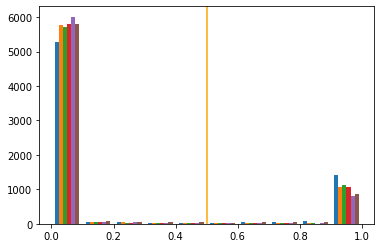

In [100]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [101]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [102]:
"{:0.2f}".format(pct_auc)

'99.53'

In [103]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [104]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [105]:
ydf.head(10)

,y_hat,y
0,5.063339e-02,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,3.014386e-17,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,1.304533e-09,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3,0.000000e+00,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,9.999671e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,6.311461e-04,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
6,1.268511e-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
7,5.017311e-03,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
8,1.128616e-06,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
9,9.535550e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
